In [1]:
import sys
sys.path.append('../scripts')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import helpers as hp
import pickle as pkl
import html
import os
import re

from keras.layers import Input, Dense, LSTM, Embedding, Merge
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adadelta
from keras.callbacks import Callback
from keras import backend as K

from sklearn.metrics import f1_score, precision_score, recall_score,\
                            average_precision_score, roc_auc_score,\
                            roc_curve, precision_recall_curve, confusion_matrix,\
                            accuracy_score

from IPython.core.interactiveshell import InteractiveShell
from matplotlib import rcParams
from importlib import reload
from harness import TrainingHarness

pd.options.display.max_colwidth = 1000

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/home/paperspace/anaconda3/envs/python-36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Testing MALSTM on balanced sentence data

In [3]:
with open('../data/raw/pretraining-snli/train_snli.txt', 'rt') as f:
    text = f.readlines()
    
sentences = pd.read_table('../data/raw/pretraining-snli/train_snli.txt', header=None)
sentences.columns = ['left', 'right', 'y']

def clean_text(x):
    "formats a single string"
    if not isinstance(x, str):
        return 'NaN'
    
    # separate possessives with spaces
    x = x.replace('\'s', ' \'s')
    
    # convert html escape characters to regular characters
    x = html.unescape(x)
    
    # separate punctuations with spaces
    def pad(x):
        match = re.findall(r'.', x[0])[0]
        match_clean = ' ' + match + ' '
        return match_clean
    rx = r'\(|\)|/|!|#|\$|%|&|\\|\*|\+|,|:|;|<|=|>|\?|@|\[|\]|\^|_|{|}|\||'
    rx += r'`|~'
    x = re.sub(rx, pad, x)
    
    # remove decimal parts of version numbers
    def v_int(x):
        return re.sub('\.\d+','',x[0])
    x = re.sub(r'v\d+\.\d+', v_int, x)
    return x

def words_to_indices(x):
    indices = list()
    x = clean_text(x)
    for token in x.split():
        indices.append(map['word2idx'][token])
    return tuple(indices)

In [4]:
from sklearn.cross_validation import train_test_split

X = sentences[['left', 'right']].applymap(words_to_indices)
y = sentences['y']

/home/paperspace/anaconda3/envs/python-36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, stratify = y)

maxlen_left = X_train['left'].apply(lambda x: len(x)).max()
maxlen_right = X_train['right'].apply(lambda x: len(x)).max()
maxlen = max(maxlen_left, maxlen_right)

X_train_left = pad_sequences(X_train['left'], maxlen=maxlen, padding='post', truncating='post')
X_train_right = pad_sequences(X_train['right'], maxlen=maxlen, padding='post', truncating='post')

X_test_left = pad_sequences(X_test['left'], maxlen=maxlen, padding='post', truncating='post')
X_test_right = pad_sequences(X_test['right'], maxlen=maxlen, padding='post', truncating='post')

In [6]:
glove_matrix = np.load(os.path.join(data_dir, 
                                    'embeddings',
                                    'glove-300.matrix.npy'))

In [7]:
n_hidden = 50

input_left = Input(shape=(maxlen,))
input_right = Input(shape=(maxlen,))

embedding_layer = Embedding(glove_matrix.shape[0],
                            glove_matrix.shape[1],
                            weights=[glove_matrix],
                            input_length=maxlen,
                            trainable=False)
embedded_left = embedding_layer(input_left)
embedded_right = embedding_layer(input_right)

lstm_layer = LSTM(n_hidden, go_backwards=False)
output_left = lstm_layer(embedded_right)
output_right = lstm_layer(embedded_left)

def distance_metric(x1, x2):
    l1 = -K.sum(K.abs(x1 - x2), axis=1, keepdims=True)
    return K.exp(l1)

merge_layer = Merge(mode=lambda x: K.exp(-K.sum(K.abs(x[0] - x[1]), axis=1, keepdims=True)),
                    output_shape=lambda x: (x[0][0], 1))

distance = merge_layer([output_left, output_right])

malstm = Model([input_left, input_right], [distance])

/home/paperspace/anaconda3/envs/python-36/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [8]:
loss = list()
val_loss = list()
acc = list()
val_acc = list()

In [9]:
compile_args = dict(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['acc'])

malstm.compile(**compile_args)

In [10]:
fit_args = dict(x = [X_train_left, X_train_right],
                  y = y_train,
                  epochs = 25,
                  batch_size = 2048,
                  validation_data = ([X_test_left, X_test_right], y_test),
                  shuffle = True,
                  #class_weight = {0: 1, 1: 5}
               )

history = malstm.fit(**fit_args)
loss.extend(history.history['loss'])
val_loss.extend(history.history['val_loss'])
acc.extend(history.history['acc'])
val_acc.extend(history.history['val_acc'])

Train on 330635 samples, validate on 36738 samples
Epoch 1/25
330635/330635 [==============================] - 41s 125us/step - loss: 0.2801 - acc: 0.5991 - val_loss: 0.2167 - val_acc: 0.6793
Epoch 2/25
330635/330635 [==============================] - 40s 122us/step - loss: 0.2088 - acc: 0.6904 - val_loss: 0.2036 - val_acc: 0.7010
Epoch 3/25
330635/330635 [==============================] - 40s 121us/step - loss: 0.1950 - acc: 0.7148 - val_loss: 0.1855 - val_acc: 0.7217
Epoch 4/25
330635/330635 [==============================] - 40s 121us/step - loss: 0.1761 - acc: 0.7431 - val_loss: 0.1786 - val_acc: 0.7345
Epoch 5/25
330635/330635 [==============================] - 40s 121us/step - loss: 0.1698 - acc: 0.7541 - val_loss: 0.1704 - val_acc: 0.7561
Epoch 6/25
330635/330635 [==============================] - 40s 122us/step - loss: 0.1645 - acc: 0.7641 - val_loss: 0.1677 - val_acc: 0.7565
Epoch 7/25
330635/330635 [==============================] - 41s 123us/step - loss: 0.1605 - acc: 0.7710

/home/paperspace/anaconda3/envs/python-36/lib/python3.6/site-packages/matplotlib/font_manager.py:1339: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


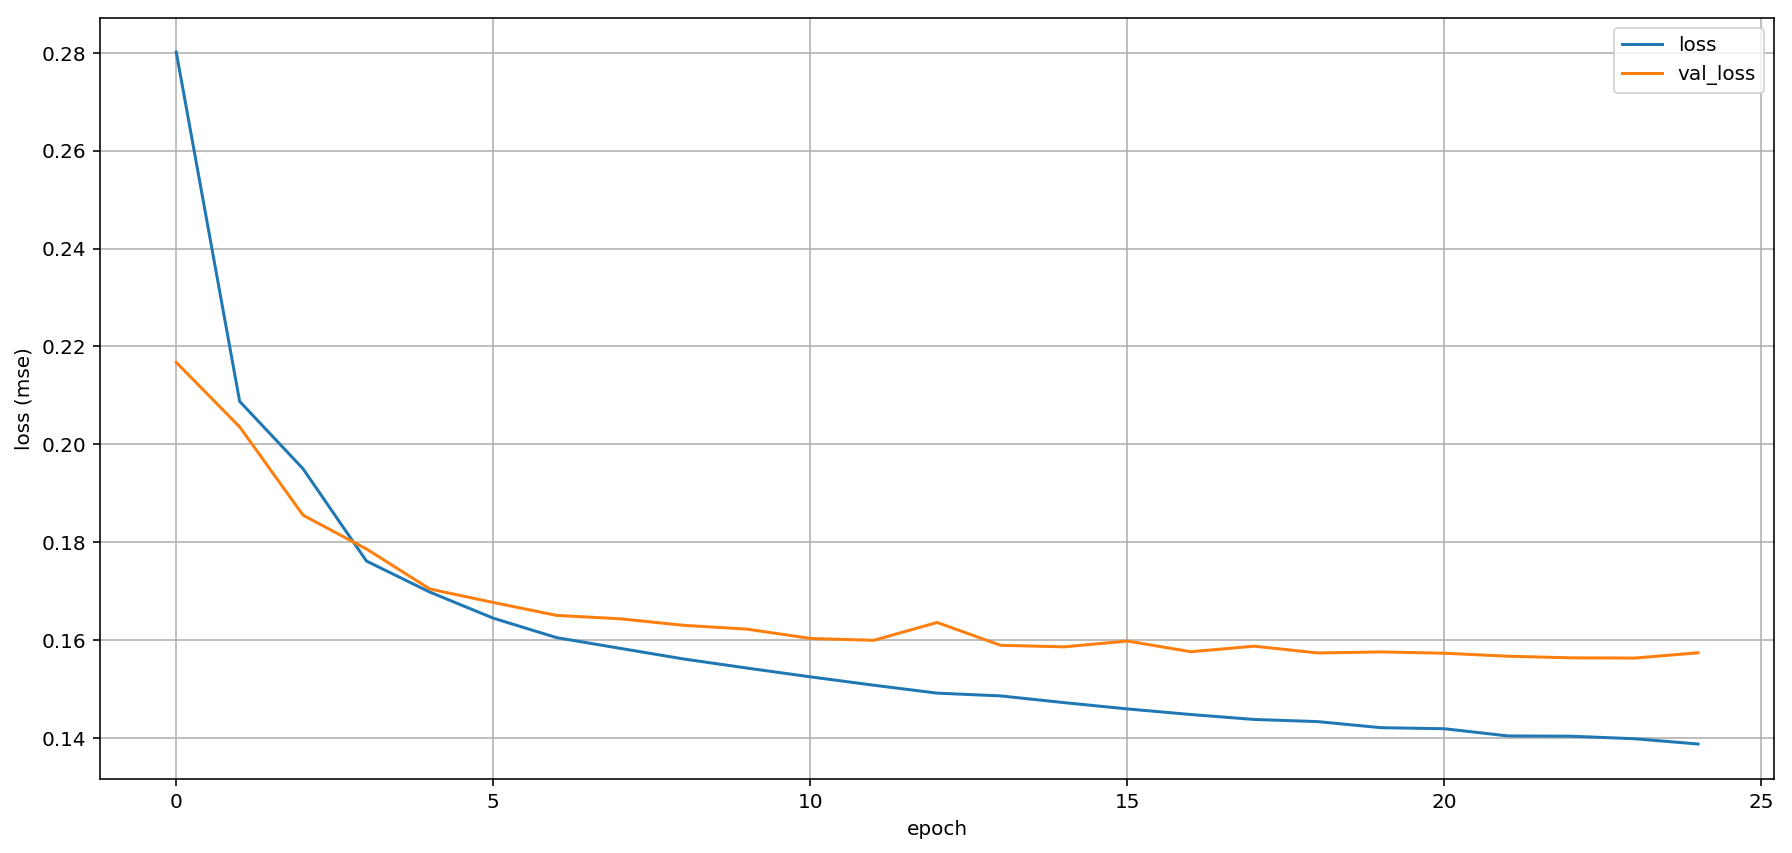

In [11]:
plt.figure(figsize = (15,7))
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss (mse)')
#plt.ylim(0.003, 0.012)
plt.grid(True)

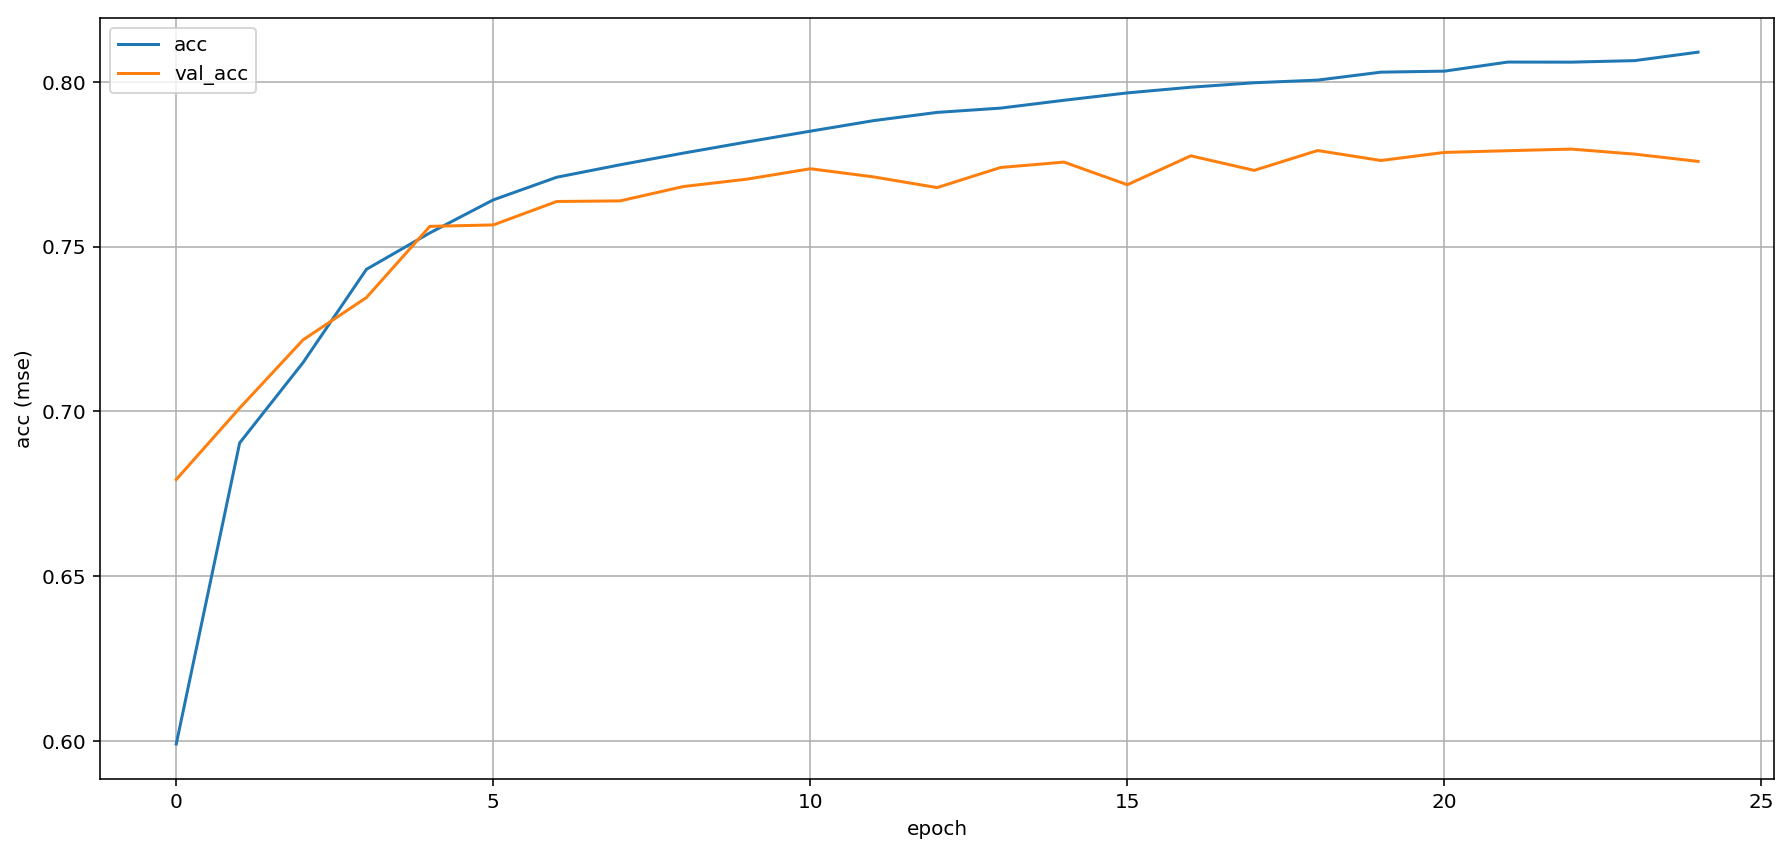

In [12]:
plt.figure(figsize = (15,7))
plt.plot(acc, label='acc')
plt.plot(val_acc, label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc (mse)')
#plt.ylim(0.988, 1)
plt.grid(True)

# Data Preprocessing

In [14]:
with open('../data/embeddings/glove-300.map', 'rb') as f:
    map = pkl.load(f)

data_dir = os.path.join('..','data')
source_dir = os.path.join(data_dir,'split','amazon-google')
data = hp.load_data(source_dir)

datasets = ['train_1', 'val_1', 'test_1', 'train_2', 'val_2', 'test_2']

# drop columns that do not contain embeddings
data['train_1'] = data['train_1'].drop(['id1', 'price'], axis = 'columns')
data['train_2'] = data['train_2'].drop(['id2', 'price'], axis = 'columns')
data['val_1'] = data['val_1'].drop(['id1', 'price'], axis = 'columns')
data['val_2'] = data['val_2'].drop(['id2', 'price'], axis = 'columns')
data['test_1'] = data['test_1'].drop(['id1', 'price'], axis = 'columns')
data['test_2'] = data['test_2'].drop(['id2', 'price'], axis = 'columns')

# concatenate all embedding columns so each record becomes one giant list
def concat_columns(x):
    y = tuple(x['title']) + tuple(x['manufacturer']) + tuple(x['description'])
    return y

for df_name in datasets:
    data[df_name] = data[df_name].apply(concat_columns, axis='columns')
    
# pad all sequences with less than 500 indices with zeros
# limit all sequences to 500 indices
maxlen = maxlen
for df_name in datasets:
    data[df_name] = pad_sequences(data[df_name], maxlen=maxlen, padding='post', truncating='post')

# Build Model

In [63]:
n_hidden = 50

input_left = Input(shape=(maxlen,))
input_right = Input(shape=(maxlen,))

embedding_layer = Embedding(glove_matrix.shape[0],
                            glove_matrix.shape[1],
                            weights=[glove_matrix],
                            input_length=maxlen,
                            trainable=False)
embedded_left = embedding_layer(input_left)
embedded_right = embedding_layer(input_right)

lstm_layer = LSTM(n_hidden, go_backwards=True, dropout = 0.5, recurrent_dropout = 0.5)
output_left = lstm_layer(embedded_right)
output_right = lstm_layer(embedded_left)

def distance_metric(x1, x2):
    l1 = -K.sum(K.abs(x1 - x2), axis=1, keepdims=True)
    return K.exp(l1)

merge_layer = Merge(mode=lambda x: K.exp(-K.sum(K.abs(x[0] - x[1]), axis=1, keepdims=True)),
                    output_shape=lambda x: (x[0][0], 1))

distance = merge_layer([output_left, output_right])

malstm = Model([input_left, input_right], [distance])

/home/paperspace/anaconda3/envs/python-36/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [15]:
loss = list()
val_loss = list()
acc = list()
val_acc = list()

In [133]:
compile_args = dict(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['acc'])

malstm.compile(**compile_args)

In [16]:
fit_args = dict(x = [data['train_1'], data['train_2']],
                  y = data['train_y'],
                  epochs = 25,
                  batch_size = 2048,
                  validation_data = ([data['val_1'], data['val_2']], data['val_y']),
                  shuffle = True,
                  #class_weight = {0: 1, 1: 5}
               )

history = malstm.fit(**fit_args)
loss.extend(history.history['loss'])
val_loss.extend(history.history['val_loss'])
acc.extend(history.history['acc'])
val_acc.extend(history.history['val_acc'])

Train on 105040 samples, validate on 13130 samples
Epoch 1/25
105040/105040 [==============================] - 13s 123us/step - loss: 0.0146 - acc: 0.9839 - val_loss: 0.0167 - val_acc: 0.9829
Epoch 2/25
105040/105040 [==============================] - 13s 121us/step - loss: 0.0120 - acc: 0.9876 - val_loss: 0.0122 - val_acc: 0.9876
Epoch 3/25
105040/105040 [==============================] - 13s 122us/step - loss: 0.0106 - acc: 0.9893 - val_loss: 0.0123 - val_acc: 0.9876
Epoch 4/25
105040/105040 [==============================] - 13s 125us/step - loss: 0.0103 - acc: 0.9897 - val_loss: 0.0120 - val_acc: 0.9882
Epoch 5/25
105040/105040 [==============================] - 13s 121us/step - loss: 0.0100 - acc: 0.9900 - val_loss: 0.0116 - val_acc: 0.9882
Epoch 6/25
105040/105040 [==============================] - 13s 123us/step - loss: 0.0100 - acc: 0.9901 - val_loss: 0.0116 - val_acc: 0.9887
Epoch 7/25
105040/105040 [==============================] - 13s 123us/step - loss: 0.0100 - acc: 0.9900

KeyboardInterrupt: 

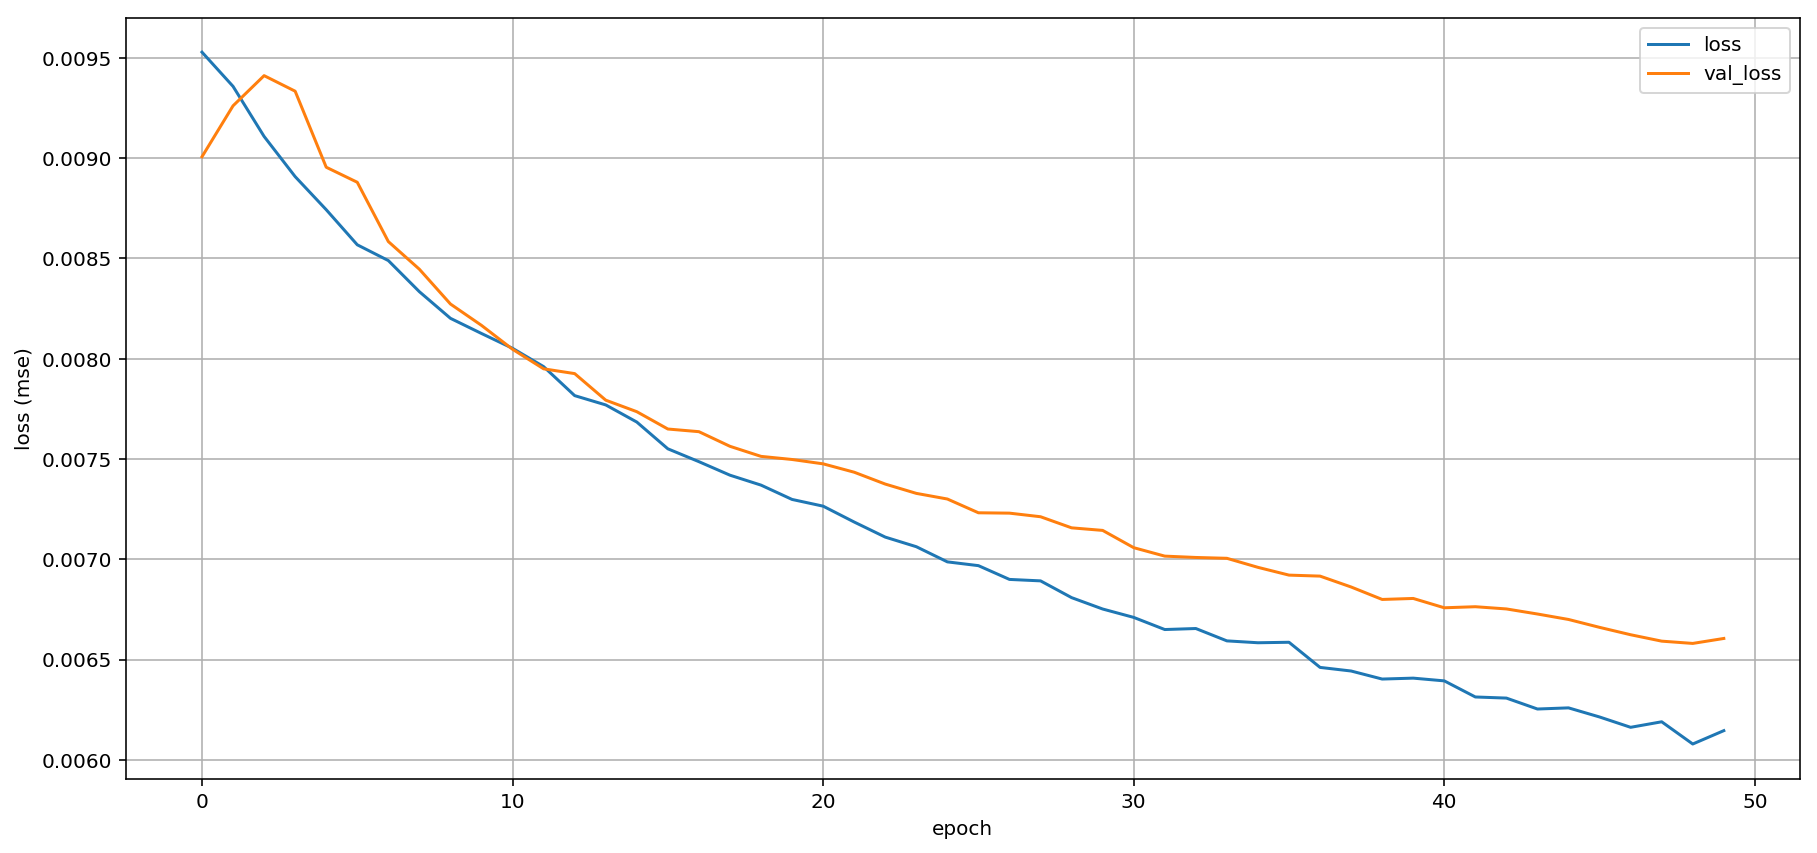

In [75]:
plt.figure(figsize = (15,7))
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss (mse)')
#plt.ylim(0.003, 0.012)
plt.grid(True)

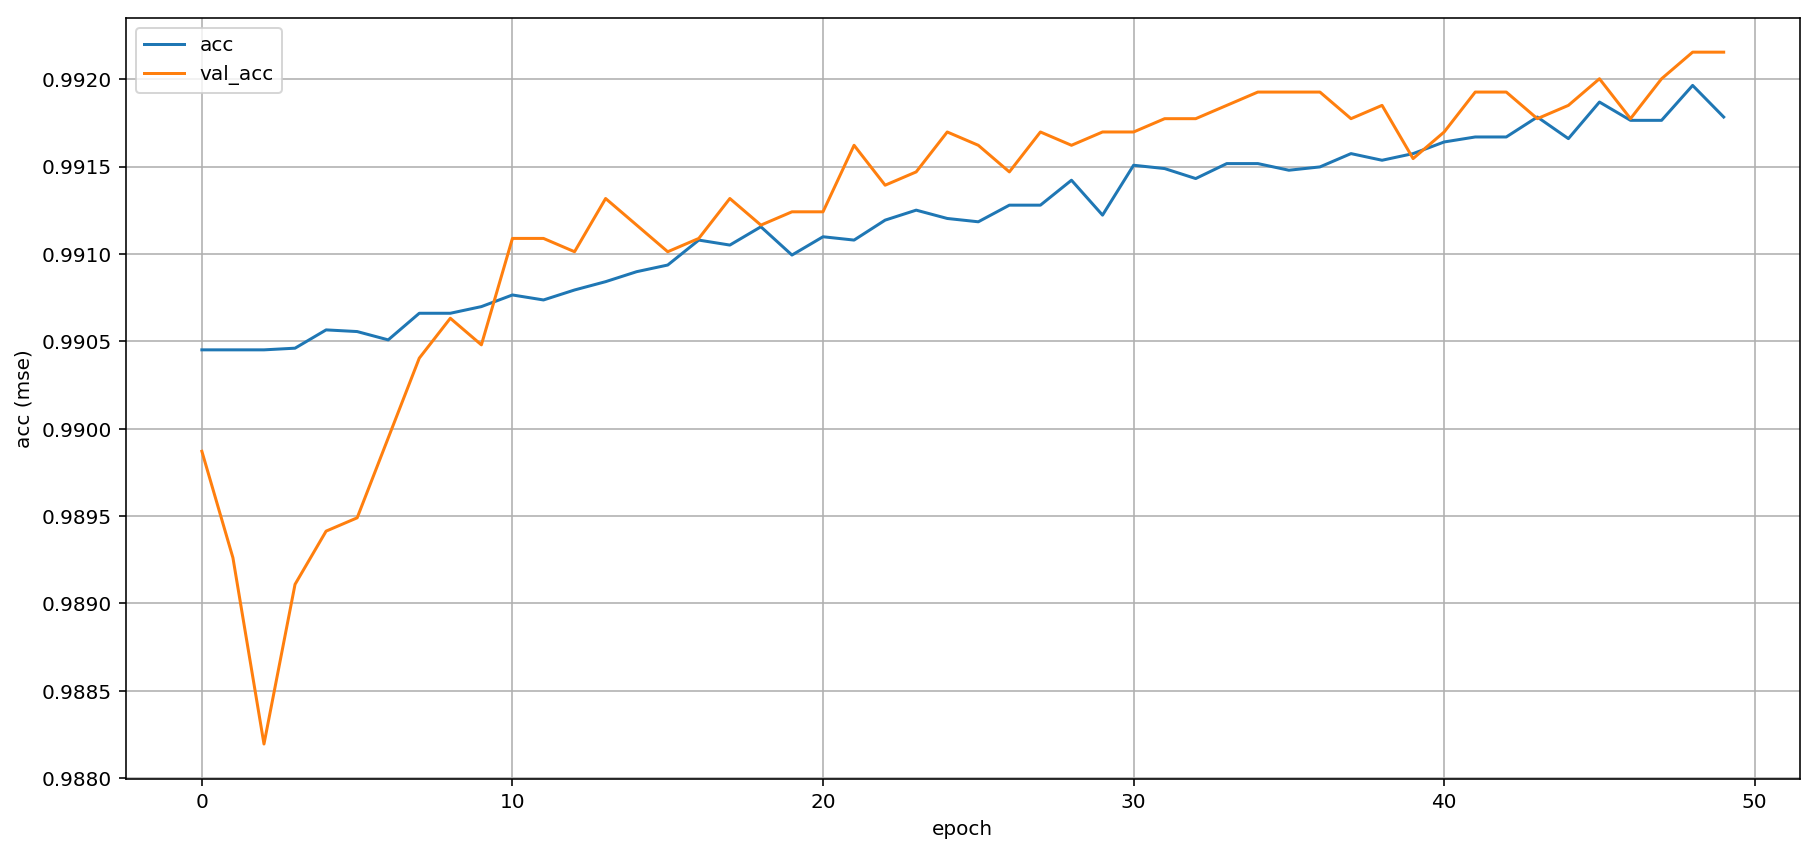

In [76]:
plt.figure(figsize = (15,7))
plt.plot(acc, label='acc')
plt.plot(val_acc, label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc (mse)')
#plt.ylim(0.988, 1)
plt.grid(True)

In [77]:
y_val_pred = malstm.predict([data['val_1'], data['val_2']])

In [79]:
accuracy_score(data['val_y'], y_val_pred >= 0.5)

0.9921553693830921

In [37]:
with open('../data/embeddings/glove-300.map', 'rb') as f:
    map = pkl.load(f)

In [38]:
import helpers as hp

val_1 = pd.read_csv('../data/split/amazon-google/val_1.csv')
val_2 = pd.read_csv('../data/split/amazon-google/val_2.csv')
train_1 = pd.read_csv('../data/split/amazon-google/train_1.csv')
train_2 = pd.read_csv('../data/split/amazon-google/train_2.csv')

def indices_to_words(x):
    string = ''
    for idx in x:
        string = string + ' ' + map['idx2word'][idx]
    return string

val_1_str = val_1[['title', 'description', 'manufacturer']].applymap(hp.str_to_list)
val_2_str = val_2[['title', 'description', 'manufacturer']].applymap(hp.str_to_list)
val_1_str = val_1_str.applymap(indices_to_words)
val_2_str = val_2_str.applymap(indices_to_words)

train_1_str = train_1[['title', 'description', 'manufacturer']].applymap(hp.str_to_list)
train_2_str = train_2[['title', 'description', 'manufacturer']].applymap(hp.str_to_list)
train_1_str = train_1_str.applymap(indices_to_words)
train_2_str = train_2_str.applymap(indices_to_words)

In [62]:
train_str = pd.concat([train_1_str, train_2_str], axis = 'columns')
train_str.loc[(data['train_y'].astype(bool).squeeze()) & train_str['title'].iloc[:,1].str.contains('family tree')]

,title,description,manufacturer,title,description,manufacturer
11309,family tree maker version 16 deluxe,with family tree maker version 16 ( deluxe edition ) you can access more than 5 billion records through ancestry.com as you research your family 's history. the best-selling genealogy program for the past 15 years family tree maker lets you access some of the world 's largest online data based including the u.s. records collection naturalization records immigration records and much more. simply enter as much personal information about your family that you know. build a family book from scratch. view just your own family or browse up to seven generations at once. find out which version of family tree maker is right for you. with family tree maker you can create a family tree is four easy steps. first you start building the tree with the information that you know. then you search through billions of records and names to add to your information. as you build your family history you can then design personal keepsakes and projects with pre-designed templates that you can then share you...,encore,family tree maker version 16 deluxe ( 10870 ),family tree maker version 16 deluxe brand : encore mpn : 10870 variant name : family tree maker version 16 deluxe,<unk>
37016,family tree maker version 16 collectors edition,with family tree maker version 16 ( collector 's edition ) you can access more than 5 billion records through ancestry.com as you research your family 's history. the best-selling genealogy program for 15 straight years family tree maker lets you access some of the world 's largest online data based including the u.s. records collection naturalization records immigration records and much more,encore software,encore inc family tree maker version 16 collectors edition,with family tree maker version 16 ( collector 's edition ) you can access more than 5 billion records through ancestry.com as you research your family 's history. the best-selling genealogy program for 15 straight years family tree maker lets you ac,<unk>
77093,family tree maker version 16 collectors edition sb cs,with family tree maker version 16 collector 's edition you'll have the world 's most popular resource for creating your family tree. in just a few steps you'll get the information you need to organize and design your family tree. import photos and documents to professionally designed templates to create a unique keepsake -- then share your findings with family and friends.,encore software,encore software 10861 - family tree maker version 16 collectors edition sb cs,encore software 10861 : encore software family tree maker version 16 collectors edition sb cs - 10861,<unk>


In [61]:
val_str = pd.concat([val_1_str, val_2_str], axis = 'columns')
val_str.loc[(y_val_pred >= 0.5).squeeze() & (data['val_y'].squeeze()), :].sample(10)

,title,description,manufacturer,title,description,manufacturer
12553,instant immersion language lab deluxe edition,the easy and fast way to multi-language learning ! product <unk> powerful and popularly priced the new and improved instant immersion language lab is the award-winning instructional software suite that talks your langua,topics entertainment,instant immersion language lab deluxe edition,overview peerless powerful and popularly priced the new and improved instant immersion language lab is the award-winning instructional software suite that talks your language ! the user-friendly language immersion for home and travel that will ...,<unk>
9243,soundtrack 1.2,brand new sealed full retail boxed edition.,apple,apple software <unk> / b soundtrack v1,produce music with thousands of loops and effects ! soundtrack brings the art of music composing to everyone. with minimal cost and effort you can produce custom music to your video dvd or web project. you wont need to license a song or hire a ...,apple software
11647,mavis beacon teaches typing deluxe v17,mavis beacon teaches typing 17 deluxe brings back the classic typing tutorial. let mavis beacon monitor your typing skills as you complete the wide range of lessons and exercises included here. the software monitors your progress flagging your weak spots and offering challenging lessons to help you improve your keyboard skills. download lessons to your palm pilot for easy portable practice sessions straighten up your keyboarding skills -- correct your posture and physical alignment with ergonomic evaluation videos includes bonus software - perfect and update your résumé with the print shop resume pro for pc,encore software,broderbund mavis beacon teaches typing <unk>,<unk> minimum system requirements : powerpc g3 <unk> processor or faster mac os 9.2 mac os 10.2.2 and higher 64 mb ram for mac os 9.2 128 mb ram for mac os <unk> 256 mb ram for mac os <unk> 16x cd-rom drive 360 mb free hard disk ...,<unk>
10738,sound studio 3 : record edit add effects to audio ( mac ),sound studio 3 is an easy-to-use mac os x application for recording and editing audio digitally on your computer. digitize vinyl records and tapes record live performances create your own mixes with crossfades tweak the levels and eq apply digital and save in all major file formats with sound studio. a perfect accessory to create and customize your own itunes tracks !,freeverse software,sound studio 3 for mac,easytouse mac os x application for recording and editing audio digitally to your computer digitize vinyl records and tapes record live performances create mixes with crossfades tweak levels and eq apply digital and save in file formats repair ...,<unk>
1802,sony vegas 6,vegas 6 combines real-time sd dv and hdv video editing with powerful audio tools for producing the high-quality results a professional would expect. this all-in-one environment mixes high-definition and high-fidelity for creative thinkers and editing <unk> the software delivers tremendous power incredible speed and maximum productivity in an uncomplicated efficient platform. over 30 customizable real-time audio effects including eq reverb delay and more new vst plug-in effects support -- expand your audio processing and mixing options new project nesting adds a vegas project to the timeline -- edit and apply effects,sony pictures digital entertainment,sony vegas 6 video editing software professional editing software,vegas 6 video editing software - hd video and audio production software installation cd-rom only ; does not include box or <unk> computers & solutions > computer media solutions > professional editing software sony sony sv 6000 dvd <unk> vegas ...,<unk>
3367,family tree maker version 16 essentials,family tree maker 2006 essentials makes it fast and easy to research your family history. the software provides an easy & complete resource for building and sharing your family tree. access more than five billion records and search through

# Pre-training

In [20]:
compile_args = dict(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['acc'])
fit_args = dict(x = [data['train_1'], data['train_2']],
                  y = data['train_y'],
                  epochs = 10,
                  batch_size = 2048,
                  validation_data = ([data['val_1'], data['val_2']], data['val_y']))
th = TrainingHarness(malstm,
                     n_checkpoints = 10,
                     compile_args = compile_args,
                     fit_args = fit_args,
                     npy_embedding_matrix = '../data/embeddings/glove-300.matrix.npy')

In [36]:
th.fit(class_weight = {0:1, 1:5}, epochs = 100)

Train on 10400 samples, validate on 1300 samples
Epoch 1/1
10400/10400 [==============================] - 9s 889us/step - loss: 0.0423 - acc: 0.9939 - val_loss: 0.0704 - val_acc: 0.9077
Train on 10400 samples, validate on 1300 samples
Epoch 1/1
10400/10400 [==============================] - 9s 906us/step - loss: 0.0438 - acc: 0.9926 - val_loss: 0.0693 - val_acc: 0.9100
Train on 10400 samples, validate on 1300 samples
Epoch 1/1
10400/10400 [==============================] - 10s 917us/step - loss: 0.0428 - acc: 0.9935 - val_loss: 0.0698 - val_acc: 0.9077
Train on 10400 samples, validate on 1300 samples
Epoch 1/1
10400/10400 [==============================] - 9s 880us/step - loss: 0.0401 - acc: 0.9939 - val_loss: 0.0690 - val_acc: 0.9062
Train on 10400 samples, validate on 1300 samples
Epoch 1/1
10400/10400 [==============================] - 9s 895us/step - loss: 0.0380 - acc: 0.9941 - val_loss: 0.0697 - val_acc: 0.9085
Train on 10400 samples, validate on 1300 samples
Epoch 1/1
10400/1040

Train on 10400 samples, validate on 1300 samples
Epoch 1/1
10400/10400 [==============================] - 9s 897us/step - loss: 0.0341 - acc: 0.9953 - val_loss: 0.0693 - val_acc: 0.9092
Train on 10400 samples, validate on 1300 samples
Epoch 1/1
10400/10400 [==============================] - 9s 881us/step - loss: 0.0363 - acc: 0.9949 - val_loss: 0.0696 - val_acc: 0.9069
Train on 10400 samples, validate on 1300 samples
Epoch 1/1
10400/10400 [==============================] - 9s 876us/step - loss: 0.0343 - acc: 0.9953 - val_loss: 0.0693 - val_acc: 0.9069
Train on 10400 samples, validate on 1300 samples
Epoch 1/1
10400/10400 [==============================] - 9s 893us/step - loss: 0.0346 - acc: 0.9957 - val_loss: 0.0693 - val_acc: 0.9077
Train on 10400 samples, validate on 1300 samples
Epoch 1/1
10400/10400 [==============================] - 9s 906us/step - loss: 0.0323 - acc: 0.9957 - val_loss: 0.0693 - val_acc: 0.9100
Train on 10400 samples, validate on 1300 samples
Epoch 1/1
10400/10400

10400/10400 [==============================] - 9s 899us/step - loss: 0.0299 - acc: 0.9965 - val_loss: 0.0689 - val_acc: 0.9077
Train on 10400 samples, validate on 1300 samples
Epoch 1/1
10400/10400 [==============================] - 9s 911us/step - loss: 0.0303 - acc: 0.9968 - val_loss: 0.0680 - val_acc: 0.9085
Train on 10400 samples, validate on 1300 samples
Epoch 1/1
10400/10400 [==============================] - 9s 905us/step - loss: 0.0300 - acc: 0.9968 - val_loss: 0.0687 - val_acc: 0.9069
Train on 10400 samples, validate on 1300 samples
Epoch 1/1
10400/10400 [==============================] - 9s 903us/step - loss: 0.0288 - acc: 0.9974 - val_loss: 0.0682 - val_acc: 0.9085
Train on 10400 samples, validate on 1300 samples
Epoch 1/1
10400/10400 [==============================] - 9s 904us/step - loss: 0.0274 - acc: 0.9968 - val_loss: 0.0684 - val_acc: 0.9108
Train on 10400 samples, validate on 1300 samples
Epoch 1/1
10400/10400 [==============================] - 9s 886us/step - loss: 0

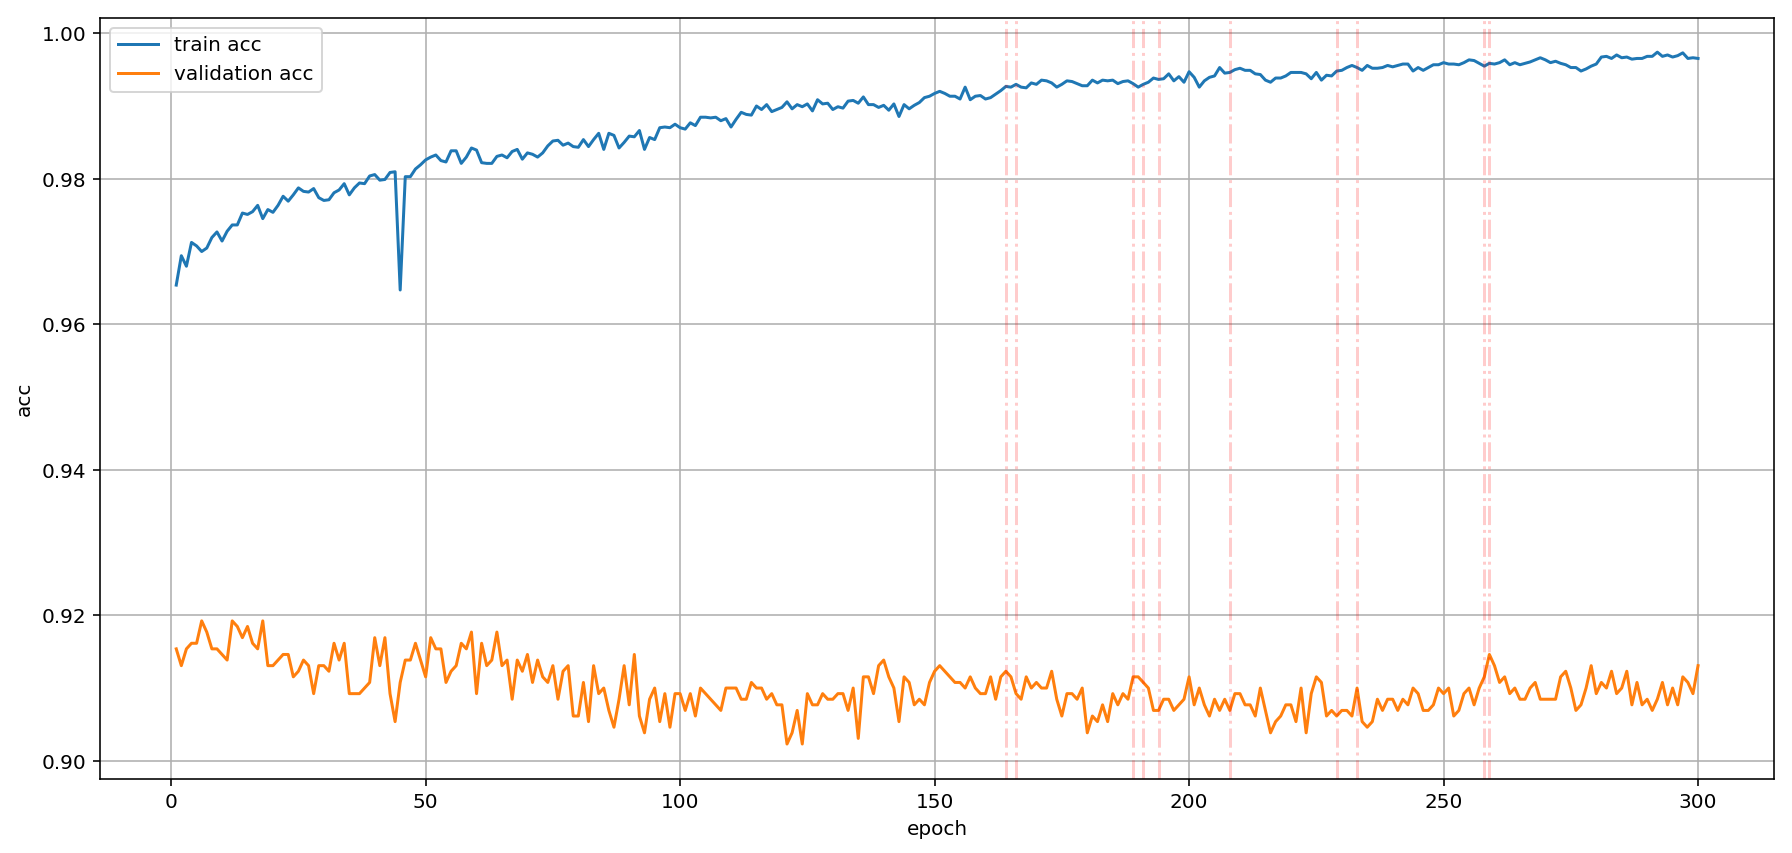

In [40]:
th.plot_history('acc')

In [42]:
y_train_pred = th.model.predict([data['train_1'], data['train_2']])
y_val_pred = th.model.predict([data['val_1'], data['val_2']])

In [60]:
confusion_matrix(data['train_y'], y_train_pred >= 0.5)

array([[9326,   26],
       [  10, 1038]])

In [62]:
confusion_matrix(data['val_y'], y_val_pred >= 0.3)

array([[1081,  106],
       [  63,   50]])

(array([889., 156.,  84.,  54.,  45.,  28.,  18.,   9.,   5.,  12.]),
 array([1.45307516e-11, 9.13808763e-02, 1.82761753e-01, 2.74142629e-01,
        3.65523505e-01, 4.56904382e-01, 5.48285258e-01, 6.39666134e-01,
        7.31047010e-01, 8.22427887e-01, 9.13808763e-01]),
 <a list of 10 Patch objects>)

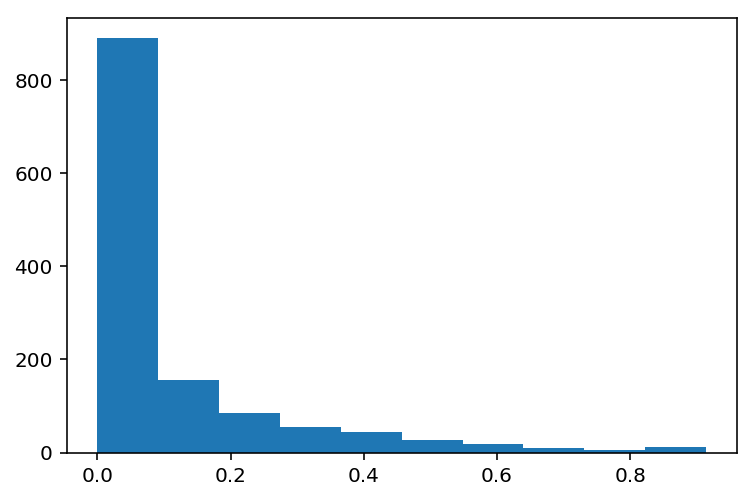

In [58]:
plt.hist(y_val_pred)

(array([7294., 1216.,  527.,  210.,   73.,   40.,   31.,  145.,  538.,
         326.]),
 array([7.77698503e-18, 9.35717642e-02, 1.87143528e-01, 2.80715293e-01,
        3.74287057e-01, 4.67858821e-01, 5.61430585e-01, 6.55002350e-01,
        7.48574114e-01, 8.42145878e-01, 9.35717642e-01]),
 <a list of 10 Patch objects>)

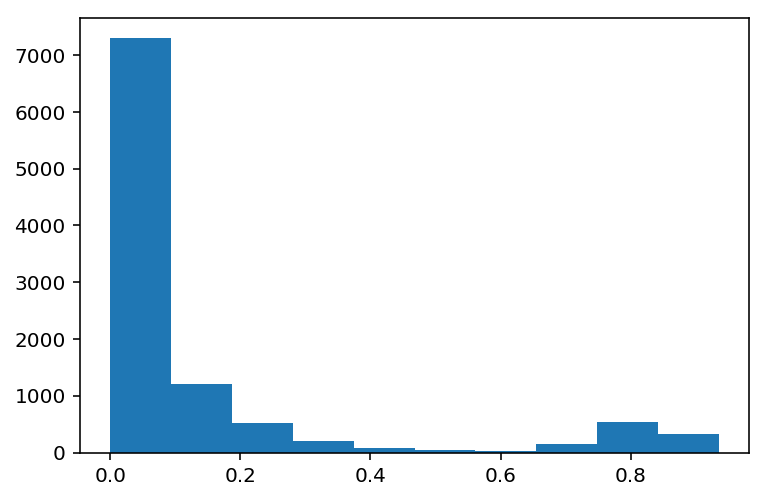

In [59]:
plt.hist(y_train_pred)